In [64]:
#libraries
import numpy as np
import pandas as pd
import torch
import os
import h5py
import yaml
import json
from types import SimpleNamespace
import seaborn as sns
import matplotlib.pyplot as pl


In [4]:
#libraries
from pathlib import Path
os.chdir(Path(os.getcwd()).parents[0]) 

In [5]:
from models import STOMP

In [ ]:
# experiment parameters
N = 10 # num agents. [10,100,1000]
corr = 0 #.8 # pairwise correlation in data generated from logit model. [0, 0.5, .99]
P = int(5e5) # training model size. big enough such that hidden width not too small? 
seq_len = 16 # context length. adjust based on distinguishability of contexts
training_sample_budget = int(1e4)

# fixed training data properties
S = 8 # state space dim 8 gives 2^8=256 distinct observations in ground system policy, big enough even for largest N?
A = 2 # single-agent action space dim

# training parameters (set as needed)
num_epochs = 50
learning_rate = 5e-4
batch_size = 8
data_seed = 0
seed = 0
evaluation_sample_size = int(1e4) # large enough for low variability of test accuracy across data_seeds

This notebook loads all objects produced by the program with the following hashes

In [ ]:
def get_all(corrvec,Nvec,Pvec):
    data_config={
        "num_train_samples": training_sample_budget,
        "num_test_samples": evaluation_sample_size,
        "outdir" : "output/",
        "num_actions":A,
        "num_agents": N,
        "state_dim": S,
        "model_name":"logit",
        "corr": corr
    }
    # training configuration for (s,a) block data
    train_config = {
        'P': P,
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'data_seed': data_seed,
        'outdir': 'output/',
        'seed': seed
        }
    
    model_config = {
        'seq_len': seq_len,
        'model_name': 'STOMP',
        'cross_talk': False,
        'decoder_type':'BuffAtt'
    }
    train_config['model_config'] = model_config

    for corr in corrvec:
        dataconfig['corr'] =1.0
        for N in Nvec:
            dataconfig['num_agents'] = N
            data_dir=generate_dataset_from_logitmodel(dataset_config)
            train_config['data_dir'] =data_dir
            train_config['model_config']['seq_len'] = seq_len
            for P in Pvec:
                train_config['P']=P
                for dec_type in ['MLP','BuffAtt']:
                    train_config['model_config']['decoder_type'] = dec_type
                    


In [ ]:
data_config=[]
dataconfig['corr'] =1.0
data_hash=get_data_hash(data_config)
train_config ={}
train_config['data_hash'] = 
train_config['model_config']['decoder_type'] = 'MLP'



In [69]:
#N=10 #rho=0 # seq len 8
data_hash ='6c56fb91e3'
train_hash = 'abb8f1af74' # STOMP MLP decoder
train_hash = 'd664d60a0d' #STOMP buffer decoder

#N=10 rho=0.8 # seq len 8
data_hash ='dae3c6772d'
train_hash = 'b1aa2e4919' # STOMP MLP decoder

Set paths

In [70]:
outdir = 'output/'
data_dir = f'data_{data_hash}/'
data_filename = os.path.join(outdir, data_dir, 'data.h5')
config_filename = os.path.join(outdir, data_dir, 'config.yaml')
save_dir = os.path.join(outdir, data_dir, 'training_results/')
train_info_dir = os.path.join(save_dir, train_hash)

Load dataset objects

In [71]:
# load the hdf data (one file for each seed)
with h5py.File(data_filename, 'r') as f:
    datasets = {}
    for group_name, group in f.items():
        datasets[group_name] = {key: np.array(
            value) for key, value in group.items()}
# load the config file
with open(config_filename, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(json.dumps(config['file_attrs'],sort_keys=True, indent=4))

{
    "corr": 0.8,
    "hash": "dae3c6772d",
    "model_name": "logit",
    "num_actions": 2,
    "num_agents": 10,
    "num_test_samples": 10000,
    "num_train_samples": 10000,
    "outdir": "output/",
    "state_dim": 8,
    "timestamp": "20240617_135730"
}


Load training objects

In [75]:
# load the training arguments
with open(train_info_dir + "/train_config.yaml", 'r') as f:
    model_config = yaml.load(f, Loader=yaml.FullLoader)
    print(json.dumps(model_config,sort_keys=True, indent=4))
    model_config = SimpleNamespace(**model_config)
# load results
results = pd.read_csv(train_info_dir + "/results.csv")
#load final state dict
state_dict_final = torch.load(train_info_dir + "/state_dict_final.pt")
# #load checkpoints
# state_dict_checkpoints = [torch.load(train_info_dir + f"/state_dict_{epoch}.pt") 
#                           for epoch in range(5,training_args['epochs']+1,5)]

{
    "P": 500000,
    "batch_size": 8,
    "data_dir": "data_dae3c6772d",
    "data_seed": 0,
    "hash": "b1aa2e4919",
    "learning_rate": 0.0005,
    "model_config": {
        "cross_talk": false,
        "decoder_type": "MLP",
        "model_name": "STOMP",
        "seq_len": 8
    },
    "num_epochs": 50,
    "outdir": "output/",
    "seed": 0
}


Text(0.5, 0.01, 'epoch')

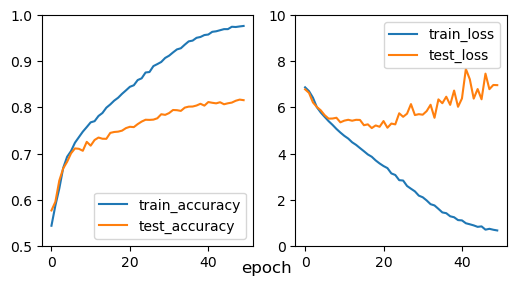

In [79]:
fig,ax=pl.subplots(1,2,figsize=(6,3))
results.plot.line(y='train_accuracy',ax=ax[0])
results.plot.line(y='test_accuracy',ax=ax[0])
results.plot.line(y='train_loss',ax=ax[1])
results.plot.line(y='test_loss',ax=ax[1])
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0,10)
fig.supxlabel('epoch')

In [77]:
model = STOMP(model_config)
untrained_state_dict=model.state_dict()
print("Model's state_dict:")
for param_tensor in untrained_state_dict:
    print(param_tensor, "\t", untrained_state_dict[param_tensor].size())
# for name, param in untrainedmodel.named_parameters():
#     print(f"{name} {param.shape}")
# weights = 
print()
for param_tensor in state_dict_final:
    print(param_tensor, "\t", state_dict_final[param_tensor].size())
# model.load_state_dict(state_dict_final)

AttributeError: 'types.SimpleNamespace' object has no attribute 'decoder_type'

In [52]:
for name, layer in model.named_modules():
    print(name)


seq_enc
seq_enc.seq_stepmodel_time
seq_enc.seq_model_agent
seq_enc.fc_in
seq_enc.fc_in.model
seq_enc.fc_in.model.0
seq_enc.fc_in.model.1
seq_enc.fc_in.model.2
seq_enc.fc_in.model.2.0
seq_enc.fc_in.model.2.1
seq_enc.fc_in.model.3
seq_enc.fc_in.model.3.0
seq_enc.fc_in.model.3.1
seq_enc.fc_in.model.4
seq_enc.fc_out
decoder
decoder.model
decoder.model.0
decoder.model.1
decoder.model.2
decoder.model.2.0
decoder.model.2.1
decoder.model.3
decoder.model.3.0
decoder.model.3.1
decoder.model.4


Text(0.02, 0.5, 'count')

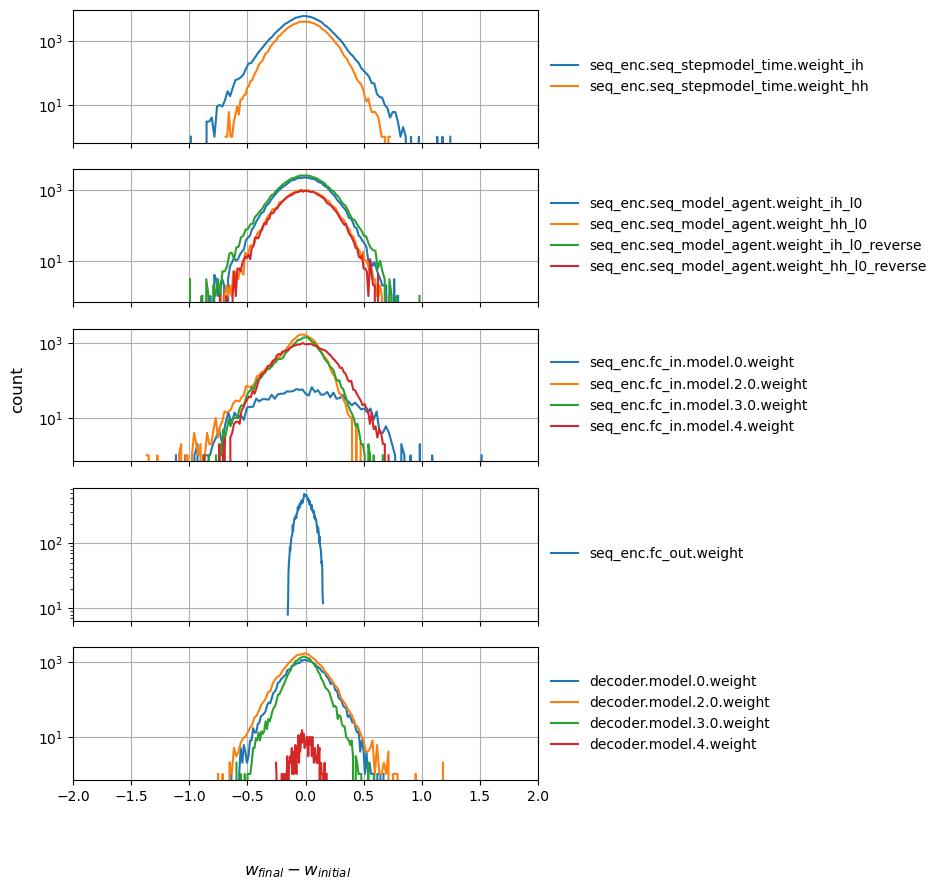

In [78]:

fig,ax=pl.subplots(5,1,figsize=(6,5*2))
for param_tensor in untrained_state_dict:
    if 'weight' in param_tensor:
        hist=torch.histogram((state_dict_final[param_tensor]-untrained_state_dict[param_tensor]).flatten())
        if 'seq_enc.seq_stepmodel_time' in param_tensor:
            ax[0].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
        elif 'seq_enc.seq_model_agent' in param_tensor:
            ax[1].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
        elif 'fc_in.model' in param_tensor:
            ax[2].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
        elif 'fc_out' in param_tensor:
            ax[3].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
        elif 'decoder.model' in param_tensor:
            ax[4].plot(hist.bin_edges[:-1], hist.hist,label=param_tensor)
for ait,axt in enumerate(ax):
    axt.set_yscale('log')
    if ait<4:
        axt.set_xticklabels([])
    axt.set_xlim(-2,2)
    axt.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    axt.grid(True)
fig.supxlabel(r'$w_{final} - w_{initial}$')
fig.supylabel('count')


In [42]:
for name, param in model.named_parameters():
    print(f"{name} {param.shape}")

seq_enc.seq_stepmodel_time.weight_ih torch.Size([672, 168])
seq_enc.seq_stepmodel_time.weight_hh torch.Size([672, 168])
seq_enc.seq_stepmodel_time.bias_ih torch.Size([672])
seq_enc.seq_stepmodel_time.bias_hh torch.Size([672])
seq_enc.seq_model_agent.weight_ih_l0 torch.Size([336, 168])
seq_enc.seq_model_agent.weight_hh_l0 torch.Size([336, 84])
seq_enc.seq_model_agent.bias_ih_l0 torch.Size([336])
seq_enc.seq_model_agent.bias_hh_l0 torch.Size([336])
seq_enc.seq_model_agent.weight_ih_l0_reverse torch.Size([336, 168])
seq_enc.seq_model_agent.weight_hh_l0_reverse torch.Size([336, 84])
seq_enc.seq_model_agent.bias_ih_l0_reverse torch.Size([336])
seq_enc.seq_model_agent.bias_hh_l0_reverse torch.Size([336])
seq_enc.fc_in.model.0.weight torch.Size([168, 10])
seq_enc.fc_in.model.0.bias torch.Size([168])
seq_enc.fc_in.model.2.0.weight torch.Size([168, 168])
seq_enc.fc_in.model.2.0.bias torch.Size([168])
seq_enc.fc_in.model.3.0.weight torch.Size([168, 168])
seq_enc.fc_in.model.3.0.bias torch.Size([

bring into a function

In [3]:
def get_all(data_hash,train_hash):
    
    #get paths
    outdir = 'output/'
    data_dir = f'data_{data_hash}/'
    data_filename = os.path.join(outdir, data_dir, 'data.h5')
    config_filename = os.path.join(outdir, data_dir, 'config.yaml')
    save_dir = os.path.join(outdir, data_dir, 'training_results/')
    train_info_dir = os.path.join(save_dir, train_hash)
    
    # load the hdf data (one file for each seed)
    with h5py.File(data_filename, 'r') as f:
        datasets = {}
        for group_name, group in f.items():
            datasets[group_name] = {key: np.array(
                value) for key, value in group.items()}
    
    # load the config file
    with open(config_filename, 'r') as f:
        data_config = yaml.load(f, Loader=yaml.FullLoader)
        
    # load the training arguments
    with open(train_info_dir + "/args.yaml", 'r') as f:
        training_args = yaml.load(f, Loader=yaml.FullLoader)
    
    # load results
    results = np.load(train_info_dir + "/results.npy", allow_pickle=True).item()
    
    #load final state dict
    state_dict_final = torch.load(train_info_dir + "/state_dict_final.pt")
    
    #load checkpoints
    state_dict_checkpoints = [torch.load(train_info_dir + f"/state_dict_{epoch}.pt") 
                              for epoch in range(5,training_args['epochs']+1,5)]
    
    return data_config, datasets, training_args, results, state_dict_final, state_dict_checkpoints

In [4]:
data_config, datasets, training_args, results, state_dict_final, state_dict_checkpoints=get_all(data_hash,train_hash)

Now, load data from a multiple runs

In [ ]:
def get_perf_data(train_hash,data_hash):
    outdir = 'output/'
    data_dir = f'data_{data_hash}/'
    data_filename = os.path.join(outdir, data_dir, 'data.h5')
    config_filename = os.path.join(outdir, data_dir, 'config.yaml')
    save_dir = os.path.join(outdir, data_dir, 'training_results/')
    train_info_dir = os.path.join(save_dir, train_hash)
    results = np.load(train_info_dir + "/results.npy", allow_pickle=True).item()
    return results

def get_data_hash (N,data_paras=data_config):
    data_paras['N']=N
    data_hash = data_hash_function(data_paras) #TODO!!!
    return data_hash

def get_train_hash (P, model_name,train_paras=training_args):
    train_paras['P']=P
    train_paras['model_name']=model_name
    train_hash = train_hash_function(train_paras) #TODO!!!
    return train_hash

In [ ]:
N_list = [1e1, 1e2, 1e3, 1e4]
model_name_list= ['stomp','single','multis']
P_list = [1e5, 1e6, 1e7, 1e8, 1e9]
perf_data={}
for nit,N in enumerate(N_list):
    data_hash = get_data_hash(N, data_paras)
    perf_data[N]={}
    for pit,P in enumerate(P_list):
        perf_data[N][P]={}
        for mit,model_name in enumerate(model_name_list):
            train_hash = get_train_hash(N,P,train_paras)
            perf_data[N][P][model_name] = get_perf_data(train_hash,data_hash)

plot accuracy and loss

In [ ]:
fig,ax=pl.subplots(2,1,figsize=(10,6))
mkr=['-','--',':']
colors=pl.cm.get_cmap('viridis')(np.linspace(0, 1, len(P_list)))
for mit,model_name in enumerate(model_name_list):
    for pit,P in enumerate(P_list):
        if mit==0:
            ax[0].plot(perf_dict[N][P][model_name]['loss'],mkr[mit],color=colors[pit],label=model_name)
        else:
            ax[0].plot(perf_dict[N][P][model_name]['loss'],mkr[mit],color=colors[pit])
        ax[0].set_ylabel('per-agent action loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylim(0,0.05)
        if git==0:
            ax[1].plot(perf_dict[N][P][model_name]['accuracy'],mkr[mit],color=colors[pit],label=P)
        else:
            ax[1].plot(perf_dict[N][P][model_name]['accuracy'],mkr[mit],color=colors[pit])
        ax[1].set_ylabel('action prediction accuracy')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylim(0,1)
ax[0].legend(frameon=False,bbox_to_anchor=(1.2, 1.05),title='training seed')
ax[1].legend(frameon=False,bbox_to_anchor=(1.01, 1.05),title='model')
fig.suptitle(data_settings_str+'\n'+training_settings_str)
#     acc == (true == mdl(x).max(1).item() / true.size(0)
fig.tight_layout()
fig.savefig('results_fig.png', transparent=True, bbox_inches="tight", dpi=300)